In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# PATH = Path('../../data')
PATH = Path('/content/gdrive/My Drive/ml-practico/data')

# Load the data

Con lo que aprendimos del notebook anterior

In [3]:
import pandas as pd

title_basics = pd.read_csv(PATH / 'title.basics.tsv', sep='\t')

movie_gross = pd.read_csv(PATH / 'movie_gross.csv')
# Calculamos el id de pelicula
movie_gross['tconst'] = movie_gross.movie_imdb_link.apply(lambda x: x.split('/')[4])
# Deduplicamos los registros
movie_gross = movie_gross.groupby('tconst').gross.max().reset_index()

title_ratings = pd.read_csv(PATH / 'title.ratings.tsv', sep='\t')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
from itertools import chain
from collections import Counter

def parse_genres(genres):
    if isinstance(genres, float) or genres == r'\N': return ['no-genre']
    else: return genres.split(',')
    

# Convertimos runtimeMinutes a float. No se puede tener una columna de tipo int con NaN
title_basics.runtimeMinutes = (
    title_basics.runtimeMinutes.apply(lambda x: np.nan if not x.isdigit() else x).astype(float)
)

title_basics['genres'] = title_basics.genres.apply(parse_genres)

In [12]:
title_basics = title_basics[
    # Dejamos tvSpecial, video y tvMovie por ahora, vamos a ver de que se tratan
    ~title_basics.titleType.isin(['tvEpisode', 'tvSeries', 'tvMiniSeries', 'videoGame', 'tvShort', 'short'])
    # Que tengan valor de runtimeMinutes
    & ~title_basics.runtimeMinutes.isna()
    # Menos de 3 horas y media para no descartar a titanic
    & (title_basics.runtimeMinutes <= 3.5 * 60)
    # Descartamos los shorts
    & title_basics.genres.apply(lambda x: 'Short' not in x)
    
]

In [13]:
# Juntamos todo

movies = (
    title_basics.merge(movie_gross, on='tconst', how='left')
                .merge(title_ratings, on='tconst', how='left')
)

len(movies)

545876

### Sanity check

Se ve igual que en el notebook anterior?

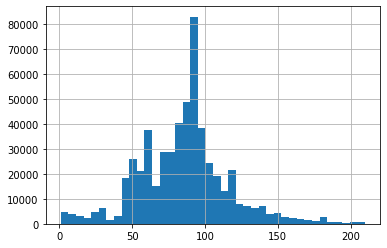

In [14]:
movies.runtimeMinutes.hist(bins=40);

Miremos un caso individual (titanic)

In [15]:
movies[movies.tconst == 'tt0120338']

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,gross,averageRating,numVotes
78839,tt0120338,movie,Titanic,Titanic,0,1997,\N,194.0,"[Drama, Romance]",658672302.0,7.8,1024063.0


# Hipótesis: el rating es buen predictor del gross

In [16]:
len(movies)

545876

In [17]:
# Only gross and rating data frame
ogr_df = movies.dropna(subset=['averageRating', 'numVotes', 'gross']).dropna()

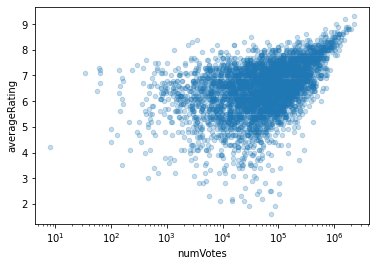

In [18]:
ogr_df.plot.scatter('numVotes', 'averageRating', alpha=0.25)
plt.xscale('log')

In [19]:
ogr_df['log(numVotes)'] = np.log10(ogr_df.numVotes)

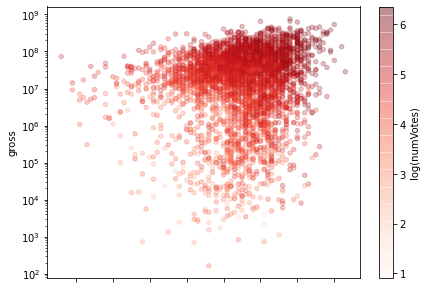

In [20]:
ogr_df.plot.scatter('averageRating', 'gross', c='log(numVotes)', cmap='Reds', alpha=0.25, figsize=(7,5))
plt.yscale('log');

No parece haber una correlacion directa, pero parece haber dos clusters diferenciados. Podrán explicarse con algun genero, u otra columna de los datos?

In [27]:

ogr_df.plot.scatter?

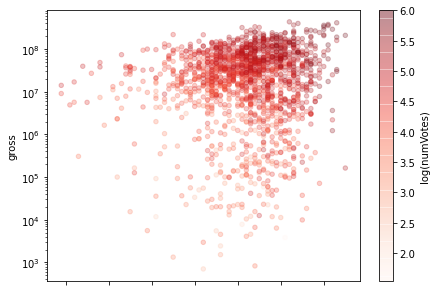

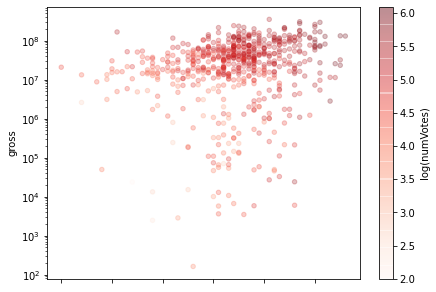

In [28]:
(
    ogr_df[ogr_df.genres.apply(lambda x: 'Comedy'  in x)]
    .plot.scatter('averageRating', 'gross', c='log(numVotes)', cmap='Reds', alpha=0.25, figsize=(7,5))
)
plt.yscale('log');
(
    ogr_df[ogr_df.genres.apply(lambda x: 'Thriller'  in x)]
    .plot.scatter('averageRating', 'gross', c='log(numVotes)', cmap='Reds', alpha=0.25, figsize=(7,5))
)

plt.yscale('log');

Habrá mas como estos?

Habrá bias en la data que tiene gross?

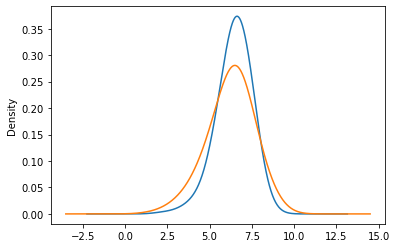

In [ ]:
ogr_df.averageRating.plot.density(bw_method=0.5)
movies[~movies.averageRating.isna()].averageRating.plot.density(bw_method=0.5)

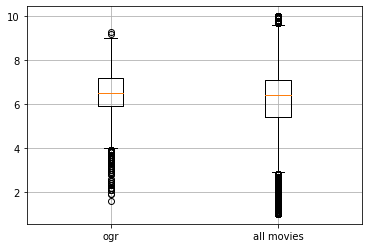

In [ ]:
plt.boxplot([ogr_df.averageRating, movies[~movies.averageRating.isna()].averageRating]);
plt.xticks([1, 2], ['ogr', 'all movies'])
plt.grid()

Si miramos numVotes, si hay una diferencia grande

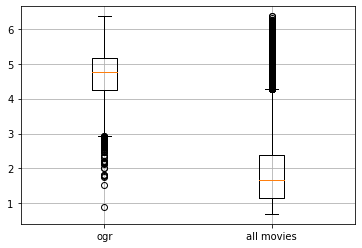

In [ ]:
plt.boxplot([np.log10(ogr_df.numVotes), np.log10(movies[~movies.averageRating.isna()].numVotes)]);
plt.xticks([1, 2], ['ogr', 'all movies'])
plt.grid()

Pareciera que las colas de la distribucion no estan bien representadas

## Tiene sentido plantarlo como clasificacion: P(gross > X dollars)?

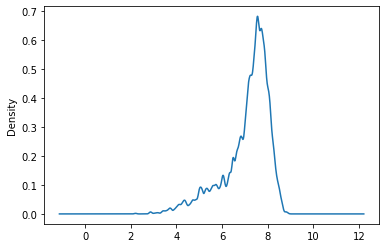

In [ ]:
np.log10(ogr_df.gross).plot.density(bw_method=0.05)

Parece haber un **sesgo grande** en la eleccion de las peliculas de movies_gross como para utilizarla para este proposito

Volvemos con el equipo de negocio y les proponemos predecir el rating como proxy. Se sienten comodes

# Si utilizamos la probabilidad de que reciba al menos un rating de X?

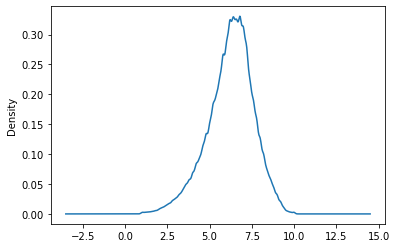

In [ ]:
movies.dropna(subset=['averageRating']).averageRating.plot.density(bw_method=0.05)

In [ ]:
# La distribucion es amplia, parece ser interesante
np.percentile(movies.averageRating.dropna(), [25, 50, 75, 85, 95])

array([5.4, 6.4, 7.2, 7.7, 8.4])

In [ ]:
movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,gross,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45.0,[Romance],NaN,5.9,154.0
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,20.0,"[Documentary, News, Sport]",NaN,5.2,356.0
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100.0,[no-genre],NaN,3.8,6.0
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70.0,"[Biography, Crime, Drama]",NaN,6.1,589.0
4,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0,1908,\N,120.0,"[Adventure, Fantasy]",NaN,5.2,37.0


## 🤔 Para pensar 

Cuantos votos tiene que tener una pelicula para usarla en training / testing?

Qué metrica usamos? 
* Accuracy? 
* ROC AUC?
* f1?
* Otra?

## Train test set split

In [30]:
movies['startYear'] = movies['startYear'].apply(lambda x: np.nan if x == r'\N' else int(x))

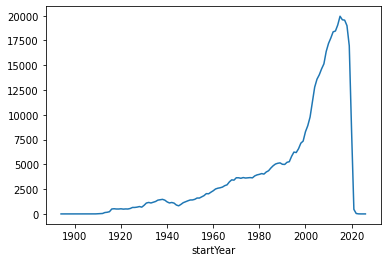

In [31]:
movies.groupby('startYear').tconst.agg('count').plot()

In [32]:
movies = movies[movies.startYear > 1970].dropna(subset=['averageRating'])

In [33]:
train_df = movies[movies.startYear <= 2017]
test_df = movies[movies.startYear > 2017]

len(train_df), len(test_df), len(test_df) / len(train_df)

(222125, 21170, 0.09530669667979741)

In [34]:
y_train = (train_df.averageRating >= 7.4).values
y_test = (test_df.averageRating >= 7.4).values

In [35]:
y_train.sum() / len(y_train), y_test.sum() / len(y_test)

(0.20899043331457512, 0.2155880963627775)

# Feature engineering 101

## Hay relacion entre el genero y la pelicula?

In [36]:
# Vamos a usar todo como listas de diccionarios para poder usar el ecosistema de sklearn de forma sencilla

train_docs = train_df.to_dict(orient='records')
test_docs = test_df.to_dict(orient='records')

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin

class GenreDummies(BaseEstimator, TransformerMixin):
    def fit(self, X, y): return self

    def transform(self, X):
        res = []
        for e in X:
            res.append({g: 1 for g in e['genres']})
        return res        

In [38]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [39]:
from sklearn.metrics import roc_auc_score

def test_pipe(pipe):
    return {
        'train_auc': roc_auc_score(y_train, pipe.predict_proba(train_docs)[:, 1]),
        'test_auc': roc_auc_score(y_test, pipe.predict_proba(test_docs)[:, 1])
    }

In [49]:
pipe = make_pipeline(
    GenreDummies(), DictVectorizer(sparse=False), 
    StandardScaler(), 
    LogisticRegression()
)

pipe.fit(train_docs, y_train);

In [50]:
test_pipe(pipe)

{'test_auc': 0.7076026631768735, 'train_auc': 0.7379019135643894}

## Cómo controlamos por el año?

Tiene sentido?

In [52]:
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin

class YearsAgo(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.now = datetime.now().year
        
    def fit(self, X, y): return self

    def transform(self, X):
        res = []
        for e in X:
            res.append({'years_ago': self.now - int(e['startYear'])})
        return res

In [57]:
from sklearn.pipeline import make_union

pipe = make_pipeline(
    make_union(
        make_pipeline(YearsAgo(), DictVectorizer(sparse=False)),
        make_pipeline(GenreDummies(), DictVectorizer(sparse=False))
    ),
    StandardScaler(),
    LogisticRegression()
)

pipe.fit(train_docs, y_train);

In [58]:
test_pipe(pipe)

{'test_auc': 0.7095836029826922, 'train_auc': 0.7394653968567885}

No afecta mucho la metrica.

**Challenge**: esto realmente controla algo? sirve para algo?

## Cómo podemos incorporar información de la crew?

### ETL

In [59]:
principals_df = pd.read_csv(PATH / 'title.principals.tsv', sep='\t')

In [61]:
principals_df.head()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


In [62]:
principals_df.category.value_counts()

actor                  9428011
actress                7087536
self                   6992466
writer                 5443248
director               4739306
producer               2533985
cinematographer        1472541
composer               1461940
editor                 1375324
production_designer     302528
archive_footage         245691
archive_sound             2605
Name: category, dtype: int64

En las peliculas hay mas de un director

El director puede estar en ordering random 

ejemplos tt4898864 (10 directores)

titanic tt0120338 director en ordering 5 

In [63]:
# Me quedo solo con los que fueron directores
movies_directors = principals_df[principals_df.category == 'director'].copy()
# Calculo un ranking por pelicula segun el ordering
movies_directors['director_rank'] = (
    movies_directors.sort_values('ordering')
                    .groupby('tconst')
                    .cumcount()
)

In [64]:
# Me quedo con el "director principal" por pelicula
movies_directors = movies_directors[movies_directors.director_rank == 0]

In [65]:
# Sanity check, no debería haber repetidos
movies_directors.tconst.value_counts().max()

1

In [66]:
# me quedo solo con la columna del director
movies_directors = (
    movies_directors.rename(columns={'nconst': 'director'})
    [['tconst', 'director']]
)

In [67]:
# Tenemos un mapping pelicula -> director
movies_directors.head()

,tconst,director
1,tt0000001,nm0005690
3,tt0000002,nm0721526
5,tt0000003,nm0721526
9,tt0000004,nm0721526
13,tt0000005,nm0005690


In [68]:
train_df = train_df.merge(movies_directors, on='tconst', how='left').fillna('-')
test_df = test_df.merge(movies_directors, on='tconst', how='left').fillna('-')

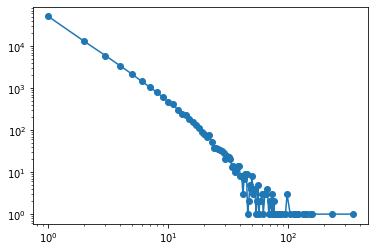

In [69]:
# Distribución de cantidad de peliculas por director

director_movies_distr = (
    train_df[train_df.director != '-']
            .director
            .value_counts()
            .value_counts()
            .sort_index()
)

director_movies_distr.plot(style='-o', logx=True, logy=True)

In [ ]:
(director_movies_distr.cumsum() / director_movies_distr.sum()).head(10)

1     0.643312
2     0.803722
3     0.873731
4     0.912310
5     0.935839
6     0.951437
7     0.962051
8     0.969871
9     0.976061
10    0.980375
Name: director, dtype: float64

In [ ]:
(train_df.director == '-').sum() / len(train_df)

0.09250902003550007

El 9% de los casos no tenemos info del director.

La mayoria (64%) de los directores hicieron una peli nada mas

In [ ]:
# Sanity check: como se ve titanic?
train_df[train_df.tconst == 'tt0120338']

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,gross,averageRating,numVotes,director
35537,tt0120338,movie,Titanic,Titanic,0,1997.0,\N,194.0,"[Drama, Romance]",6.58672e+08,7.8,1024063.0,nm0000116


In [ ]:
(train_df.director.value_counts() >= 2).sum()

26046

### Transformer & experiments

In [70]:
from collections import Counter

class DirectorFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, min_cnt_movies = 2):
        self.min_cnt_movies = min_cnt_movies
        
    def fit(self, X, y): 
        # Llevamos las cosas de nuevo a un DataFrame y calculamos features por director
        directors_stats = (
            pd.DataFrame(X)
                .groupby('director')
                .agg(
                    n_films=('tconst', 'count'),
                    min_rating=('averageRating', 'min'),
                    avg_rating=('averageRating', 'mean'),
                    max_rating=('averageRating', 'max'),
                    min_votes=('numVotes', 'min'),
                    avg_votes=('numVotes', 'mean'),
                    max_votes=('numVotes', 'max'),
            )
        )

        # Guardamos las estadisticas
        self.directors_stats_ = directors_stats

        # Diccionario con los datos para los directores comunes
        self.directors_stats_lk_ = (
            directors_stats[directors_stats.n_films >= self.min_cnt_movies].to_dict(orient='index')
        )

        # Valor default para los que consideramos que tenemos demasiado poca data
        self.default_ = directors_stats[directors_stats.n_films < self.min_cnt_movies].mean(0).to_dict()
        if self.min_cnt_movies > 1:
            self.default_ = directors_stats[directors_stats.n_films < self.min_cnt_movies].mean(0).to_dict()
        else:
            self.default_ = directors_stats.mean(0).to_dict()
        return self

    def transform(self, X):
        res = []
        for e in X:
            if e['director'] in self.directors_stats_lk_:
                res.append(self.directors_stats_lk_[e['director']])
            else:
                res.append(self.default_)
        return res            

In [71]:
train_docs = train_df.to_dict(orient='records')
test_docs = test_df.to_dict(orient='records')

In [81]:
# Lo importante de estandarizar las variables con una regresion logistica!
pipe = make_pipeline(
    DirectorFeatures(), DictVectorizer(sparse=False), LogisticRegression()
)

pipe.fit(train_docs, y_train);
test_pipe(pipe)

{'test_auc': 0.44347759323340996, 'train_auc': 0.29759088024993047}

In [82]:
# Lo mismo, standarizando
pipe = make_pipeline(
    DirectorFeatures(), DictVectorizer(sparse=False), StandardScaler(), LogisticRegression()
)

pipe.fit(train_docs, y_train)
test_pipe(pipe)

{'test_auc': 0.6049611910755678, 'train_auc': 0.769803003329768}

In [86]:
# Juntamos todas las features

from sklearn.pipeline import make_union

pipe = make_pipeline(
    make_union(
        make_pipeline(YearsAgo(), DictVectorizer(sparse=False)),
        make_pipeline(GenreDummies(), DictVectorizer(sparse=False)),
        make_pipeline(DirectorFeatures(min_cnt_movies=4), DictVectorizer(sparse=False))
    ),
    StandardScaler(),
    LogisticRegression()
)
pipe.fit(train_docs, y_train)
test_pipe(pipe)

{'test_auc': 0.7215173089819071, 'train_auc': 0.7958078294510216}

# Para seguir

* Como podes explotar aún mas el cast and crew?
* Como podes manejar el caso donde no sabemos mucho sobre el director? Esta bien min_count=2? debería ser mayor? menor?
* Qué otras familias de modelos no-lineales podemos probar?